In [1]:
import gc
import re
import string
import numpy as np
import pandas as pd
from itertools import chain
from functools import reduce
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline


import bokeh.plotting as bp
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_file, reset_output
from bokeh.io import output_notebook, save, output_file
output_notebook()


from PIL import Image
from sklearn.manifold import TSNE
# import MulticoreTSNE as TSNE
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from string import punctuation


from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_colwidth = 200
# plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

/home/kranthi/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Loading BokehJS ...

/home/kranthi/anaconda3/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
def get_data():
    train = pd.read_csv("../data/train_10_skf.csv")
    test = pd.read_csv("../data/test.csv", sep="\t")
    
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    return train, test

In [3]:
train, test = get_data()

Train Shape : (1199998, 4)
Test Shape :  (92, 3)


In [4]:
train.head()

,title,description,category,fold_id
0,ZicZac // Black + Red (Euro: 44),Clothing & related products (B2C) - Shoes and shoe laces,R,1
1,9X9 RESISTA/484938,Publishing/Printing - Printing Services,S,1
2,Halle Pant - Short Inseam 013049561D0010001_ 02,Clothing & related products (B2C) - General,R,1
3,Harry Houser Travel Expenses - Meals,Security - personnel,S,1
4,Tee Time: 740078609 : Greens Fee - Composite,Admissions - Green Fees for Privately Owned Golf Course,R,1


In [5]:
test.head()

,title,description,category
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,R
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic platforms.,S
2,Application Services,"Application Services include access to, and use of, the website, mobile application, and Internet service under the control of Radloop, whether partial or otherwise, in connection with providing t...",S
3,Carpet Repairs,NaN,S
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,R


### Missing Values

In [6]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [7]:
miss_train, miss_test = missing_values(train), missing_values(test)
miss_test

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.
Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
description,16,17.4


#### It seems we have 18% of null descriptions in test dataset. We have to find a way to impute those if we intend to use the description text as feature.

### Target Visualisation

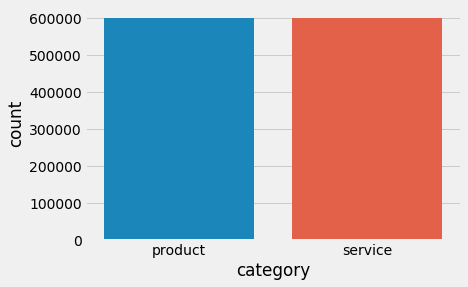

In [8]:
target = 'category'
train[target] = train[target].map({"S": "service", "R": "product"})

sns.countplot(train[target])

#### We don't have the class imbalance here. Atleast not in train dataset.

### Text Length Distribution

Let's check how the textual features length are distributed : 
    
    1. Title
    2. Description

#### Tokenize fucntion

In [9]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()
tokenize(train['title'].iloc[0])

['ZicZac', '/', '/', 'Black', '+', 'Red', '(', 'Euro', ':', '44', ')']

In [10]:
%%time

train['full_text'] = train['title'] + " " + train['description']
train['title_tokenized'] = train['title'].progress_apply(lambda x: tokenize(x))
train['description_tokenized'] = train['description'].progress_apply(lambda x: tokenize(x))
train['full_text_tokenized'] = train['full_text'].progress_apply(lambda x: tokenize(x))

100%|██████████| 1199998/1199998 [00:30<00:00, 39293.52it/s]


CPU times: user 1min 9s, sys: 2.08 s, total: 1min 11s
Wall time: 1min 12s


#### Title

Max length is selected using 95% percentile using [MEAN + 2 * STD]


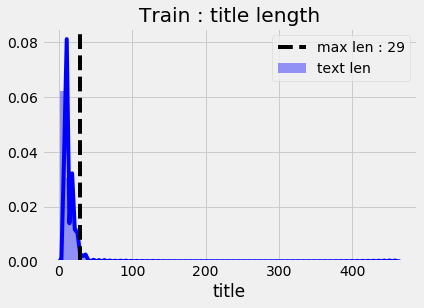

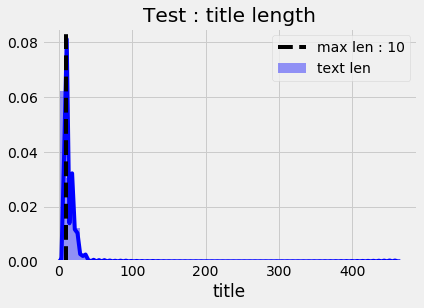

In [11]:
col = 'title'
x_trn = train[col].apply(lambda doc: len(tokenize(doc)))
max_len_trn = np.round(x_trn.mean() + 2*x_trn.std()).astype(int)
x_tst = test[col].apply(lambda doc: len(tokenize(doc)))
max_len_tst = np.round(x_tst.mean() + 2*x_tst.std()).astype(int)

print("Max length is selected using 95% percentile using [MEAN + 2 * STD]")

sns.distplot(x_trn, hist=True, kde=True, color='b', label='text len')
plt.axvline(x=max_len_trn, color='k', linestyle='--', label='max len : {}'.format(max_len_trn))
plt.title('Train : {} length'.format(col))
plt.legend()
plt.show()

sns.distplot(x_trn, hist=True, kde=True, color='b', label='text len')
plt.axvline(x=max_len_tst, color='k', linestyle='--', label='max len : {}'.format(max_len_tst))
plt.title('Test : {} length'.format(col))
plt.legend()
plt.show()

#### Description

Max length is selected using 95% percentile using [MEAN + 2 * STD]


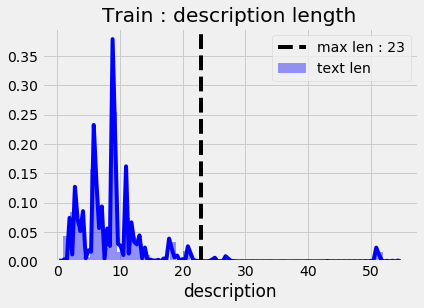

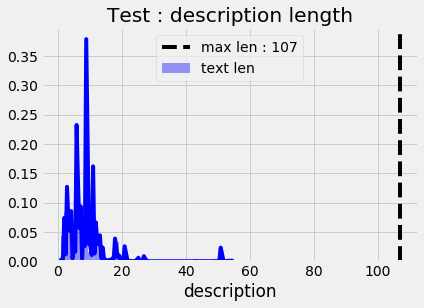

In [12]:
col = 'description'
x_trn = train[col].apply(lambda doc: len(tokenize(doc)))
max_len_trn = np.round(x_trn.mean() + 2*x_trn.std()).astype(int)
x_tst = test[col][~test[col].isnull()].apply(lambda doc: len(tokenize(doc)))
max_len_tst = np.round(x_tst.mean() + 2*x_tst.std()).astype(int)

print("Max length is selected using 95% percentile using [MEAN + 2 * STD]")

sns.distplot(x_trn, hist=True, kde=True, color='b', label='text len')
plt.axvline(x=max_len_trn, color='k', linestyle='--', label='max len : {}'.format(max_len_trn))
plt.title('Train : {} length'.format(col))
plt.legend()
plt.show()

sns.distplot(x_trn, hist=True, kde=True, color='b', label='text len')
plt.axvline(x=max_len_tst, color='k', linestyle='--', label='max len : {}'.format(max_len_tst))
plt.title('Test : {} length'.format(col))
plt.legend()
plt.show()

### Basic target keyword checking

As for a simple baseline let's build it using :

    - If the keyword "product" is in any of the textual features then predict it as "R"
    - Else If the keyword "service" is in any of the textual features then predict it as "S"
    - Else If both the keyword "service" & "product" is in any of the textual features then predict it as "both"
    - Else If none the keyword "service" & "product" is in any of the textual features then predict it as "none"

In [13]:
train.isnull().sum()

title                    0
description              0
category                 0
fold_id                  0
full_text                0
title_tokenized          0
description_tokenized    0
full_text_tokenized      0
dtype: int64

In [14]:
def check_target_keyword(X):
    if ("product" in X) & ("service" in X):
        return "both"
    if "product" in X:
        return "P"
    if "service" in X:
        return "S"
    return "none"

for data in [train, test]:
    print("Baseline Scores : ")
    data['target_keyword_in_title'] = np.nan
    data['target_keyword_in_desc'] = np.nan
    data['target_keyword_in_title'] = data['title'].progress_apply(lambda x: 
                                                                   check_target_keyword(str(x).lower()))
    data['target_keyword_in_desc'] = data['description'].progress_apply(lambda x: 
                                                                        check_target_keyword(str(x).lower()))

    print(data.groupby(['target_keyword_in_desc'])[target].value_counts())
    print(data.groupby(['target_keyword_in_title'])[target].value_counts())

  2%|▏         | 24166/1199998 [00:00<00:04, 241655.05it/s]

Baseline Scores : 


100%|██████████| 1199998/1199998 [00:02<00:00, 419873.72it/s]


target_keyword_in_desc  category
P                       product     258258
                        service         33
S                       service     211471
                        product        962
both                    service        332
none                    service     388340
                        product     340602
Name: category, dtype: int64


100%|██████████| 92/92 [00:00<00:00, 23486.06it/s]

target_keyword_in_title  category
P                        service       3220
                         product        368
S                        service      60593
                         product       2160
both                     service        426
                         product          6
none                     product     597288
                         service     535937
Name: category, dtype: int64
Baseline Scores : 
target_keyword_in_desc  category
P                       S            3
S                       S           14
both                    S            1
none                    S           39
                        R           35
Name: category, dtype: int64
target_keyword_in_title  category
P                        R            2
                         S            1
S                        S           11
none                     S           45
                         R           33
Name: category, dtype: int64


In [15]:
(258258 / (258258 + 33))*100

99.98722371278906

In [16]:
(211471 / (962 + 211471))* 100

99.54715133712747

### We can see here that we can almost classify where the single-word occurence is there : 

**Precision as metric**

1. Product :  : 99.98%
1. Service : Precision : 99.54%

### WordClouds

In [17]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='white',
                    stopwords=stopwords,
                    max_words=max_words,
                    max_font_size=max_font_size, 
                    random_state=13,
                    mask=mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                              'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

#### Title

20515

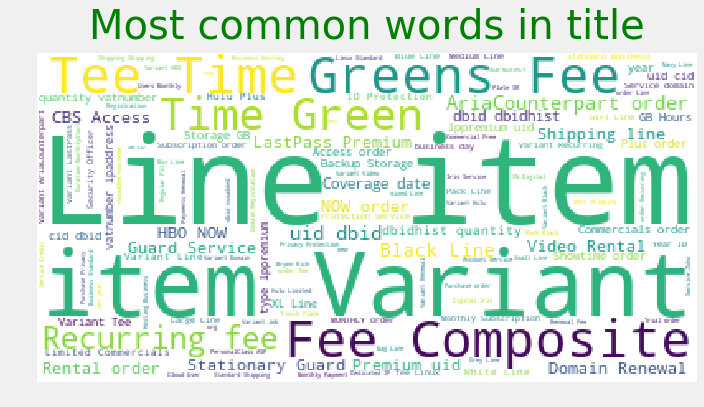

In [18]:
col = 'title'
text_data = " ".join(train[col].values.tolist()) # str(
plot_wordcloud(text_data, max_words=800, max_font_size=80, figure_size=(10,7),
               title = 'Most common words in {}'.format(col))
del text_data
gc.collect()

#### Title seperated by classes

35

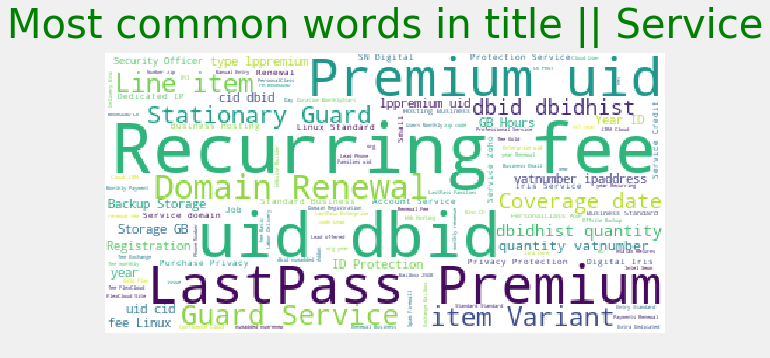

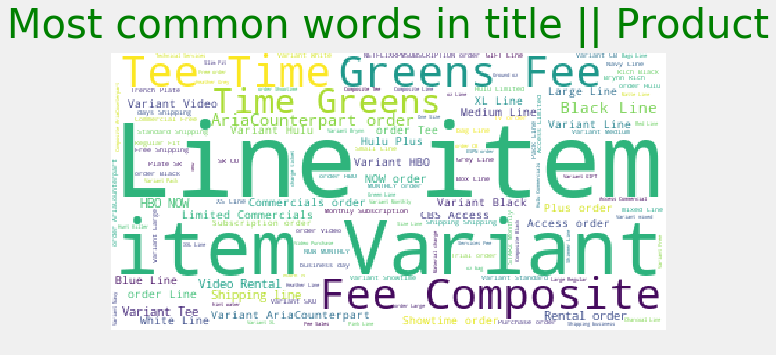

In [19]:
col = 'title'
text_data = " ".join(train[col][train[target] == 'service'].values.tolist()) # str(
plot_wordcloud(text_data, max_words=800, max_font_size=80, figure_size=(10,7),
               title = 'Most common words in {} || Service'.format(col))
del text_data
gc.collect()

col = 'title'
text_data = " ".join(train[col][train[target] == 'product'].values.tolist()) # str(
plot_wordcloud(text_data, max_words=800, max_font_size=80, figure_size=(10,7),
               title = 'Most common words in {} || Product'.format(col))
del text_data
gc.collect()

#### We still can't see any particular differences in the titles unless we check deeply and can see that mostly product wordcloud has product names whereas Service plot has keywords ike *services* explicitly.

#### Description

35

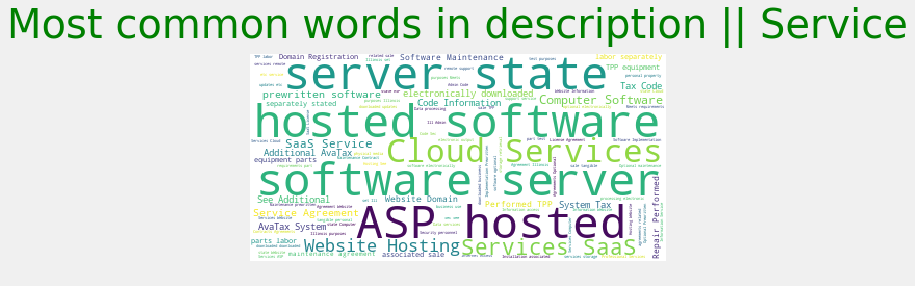

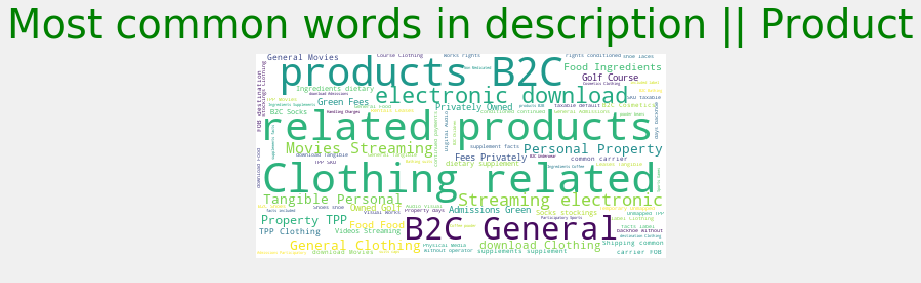

In [20]:
col = 'description'
text_data = " ".join(train[col][train[target] == 'service'].values.tolist()) # str(
plot_wordcloud(text_data, max_words=800, max_font_size=80, figure_size=(10,7),
               title = 'Most common words in {} || Service'.format(col))
del text_data
gc.collect()

text_data = " ".join(train[col][train[target] == 'product'].values.tolist()) # str(
plot_wordcloud(text_data, max_words=800, max_font_size=80, figure_size=(10,7),
               title = 'Most common words in {} || Product'.format(col))
del text_data
gc.collect()

#### Here we can clearly see that : 

    1. Service Cloud : Has keywords like software, server, services, cloud which are services not product names.
    2. Product Cloud : Has keywords like products, B2C, clothing, which are products.
    
So, we can hypothesize that description is a very important feature in classifying the product into Product/Service category.

Hence we need to find a way to impute the missing descriptions in test dataset.

### Word2Vec embeddings + T-SNE

In [21]:
train_subsample = train[train['fold_id'] == 1]
train_subsample.shape

(120001, 10)

#### Title

In [22]:
col = 'title'

values = train_subsample['{}_tokenized'.format(col)].values.tolist()
model = Word2Vec(values, min_count=10)
print("Length of Vocabulary : {}".format(len(model.wv.vocab)))

tokens_flat = list(chain.from_iterable(values))
vocab = Counter(tokens_flat)

N = 1000  # Top N words
top_words = []
count_top_N = []

for word, count in vocab.most_common(N):
    top_words.append(word)
    count_top_N.append(count)

top_words_vec = model[top_words]
tsne = TSNE(n_components=2, random_state=13)
top_words_tsne = tsne.fit_transform(top_words_vec)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common {} words".format(N))

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=10, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Length of Vocabulary : 6676


#### Description

In [23]:
col = 'description'

values = train_subsample['{}_tokenized'.format(col)].values.tolist()
model = Word2Vec(values, min_count=10)
print("Length of Vocabulary : {}".format(len(model.wv.vocab)))

tokens_flat = list(chain.from_iterable(values))
vocab = Counter(tokens_flat)

N = 500  # Top N words
top_words = []
count_top_N = []

for word, count in vocab.most_common(N):
    top_words.append(word)
    count_top_N.append(count)

top_words_vec = model[top_words]
tsne = TSNE(n_components=2, random_state=13)
top_words_tsne = tsne.fit_transform(top_words_vec)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common {} words".format(N))

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=10, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Length of Vocabulary : 882


#### Title + Description : Full_Text

In [24]:
col = 'full_text'

values = train_subsample['{}_tokenized'.format(col)].values.tolist()
model = Word2Vec(values, min_count=10)
print("Length of Vocabulary : {}".format(len(model.wv.vocab)))

tokens_flat = list(chain.from_iterable(values))
vocab = Counter(tokens_flat)

N = 1000  # Top N words
top_words = []
count_top_N = []

for word, count in vocab.most_common(N):
    top_words.append(word)
    count_top_N.append(count)

top_words_vec = model[top_words]
tsne = TSNE(n_components=2, random_state=13)
top_words_tsne = tsne.fit_transform(top_words_vec)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common {} words".format(N))

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=10, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Length of Vocabulary : 7159


### From these T-SNE plots we can see that we are able to get the context meaning with respect to the categories such that we have clusters formed like : 

    1. A cluster having sizes [L, M, S, XS, XL, XXL, 41, 42, 38]. This will represent any clothing product sizes.
    2. A cluster having keywords [cloud, SAS, service, webpage, hosted, aws] will represent a service category.
    
Similarly many clusters can be seen in the above plots.

## Imputing Descriptions -- IDEAS

We have seen from the above EDA that description holds a lot of weight in classifying products and services.

So I here hypothsize what can be the ways we can impute the descriptions : 

1. Using Doc2Vec to find similar documents 
1. Using Mean embedding of title to find nearest title in Train and then imputing the description of the mapped title in the train set.
1. Find a keyword in title to find the optimum description from train set.
